In [44]:
#ライブラリの読み込み
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [20]:
ls ../input/titanic

gender_submission.csv  sample_submission.csv  test.csv  train.csv


In [46]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')
sample_submission = pd.read_csv('../input/titanic/gender_submission.csv')

# Sexの変換
genders = {'female': 0, 'male':1}
train['Sex'] = train['Sex'].map(genders)
test['Sex'] = test['Sex'].map(genders)

# Embarkedの変換 今回はonehot encodingしない
embarked = {'S':0, 'C':1, 'Q':2}
train['Embarked'] = train['Embarked'].map(embarked)
test['Embarked'] = test['Embarked'].map(embarked)

# 不要な列の削除
train.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

In [47]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,0.0
1,1,1,0,38.0,1,0,71.2833,1.0
2,1,3,0,26.0,0,0,7.9250,0.0
3,1,1,0,35.0,1,0,53.1000,0.0
4,0,3,1,35.0,0,0,8.0500,0.0


In [48]:
X_train = train.drop('Survived', axis=1)
Y_train = train['Survived']

In [49]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,0.0
1,1,0,38.0,1,0,71.2833,1.0
2,3,0,26.0,0,0,7.9250,0.0
3,1,0,35.0,1,0,53.1000,0.0
4,3,1,35.0,0,0,8.0500,0.0


In [51]:
# トレーニングデータを train / valid に分割
train_x, valid_x, train_y, valid_y = train_test_split(
    X_train, Y_train, test_size=0.33, random_state=0
)

# LightGBMの分類器をインスタンス化
gbm = lgb.LGBMClassifier(objective='binary')

# 学習
gbm.fit(
    train_x,
    train_y,
    eval_set=[(valid_x, valid_y)],
    callbacks=[
        lgb.early_stopping(20),   # 20回連続で改善しなければ打ち切り
        lgb.log_evaluation(0)     # ログを出したくない場合は0
        # lgb.log_evaluation(10)  # 10イテごとにログを見たいとき
    ]
)

# valid_xについて推論
oof = gbm.predict(valid_x, num_iteration=gbm.best_iteration_)
print('score', round(accuracy_score(valid_y, oof) * 100, 2))

[LightGBM] [Info] Number of positive: 231, number of negative: 365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 596, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.387584 -> initscore=-0.457480
[LightGBM] [Info] Start training from score -0.457480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

In [52]:
# valid_xについて推論
oof = gbm.predict(valid_x, num_iteration=gbm.best_iteration_)
print('score', round(accuracy_score(valid_y, oof)*100,2))  # validのscore

score 81.69


In [53]:
test_pred = gbm.predict(test, num_iteration=gbm.best_iteration_)
sample_submission['Survived'] = test_pred
sample_submission.to_csv('train_test_split.csv', index=False)  # score:75.119

In [54]:
# 指定しなかったパラメータを含め、パラメータを取得
gbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [55]:
gbm.feature_importances_
# importanceはtraining dataの列順に表示される

array([ 50,  36, 345,  36,   7, 309,  37], dtype=int32)

In [56]:
# 見やすくする
pd.DataFrame({'特徴': X_train.columns,
    'importance':gbm.feature_importances_}).sort_values('importance',
    ascending=False)

,特徴,importance
2,Age,345
5,Fare,309
0,Pclass,50
6,Embarked,37
1,Sex,36
3,SibSp,36
4,Parch,7


In [58]:
# train/valid 分割
train_x, valid_x, train_y, valid_y = train_test_split(
    X_train, Y_train, test_size=0.33, random_state=0
)

# LGBM分類器
gbm = lgb.LGBMClassifier(objective='binary', importance_type='gain', n_estimators=1000)

gbm.fit(
    train_x,
    train_y,
    eval_set=[(valid_x, valid_y)],
    # One-Hot済みなら categorical_feature は指定しない
    callbacks=[
        lgb.early_stopping(20),   # 20回改善しなければ打ち切り
        lgb.log_evaluation(0)     # ログ不要なら0
    ]
)

# 特徴量重要度
importances = pd.Series(gbm.feature_importances_, index=train_x.columns)
importances.sort_values(ascending=False).head(20)

[LightGBM] [Info] Number of positive: 231, number of negative: 365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 596, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.387584 -> initscore=-0.457480
[LightGBM] [Info] Start training from score -0.457480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

Sex         1020.680608
Age          589.970572
Fare         405.479178
Pclass       299.494368
SibSp         74.489982
Embarked      68.764225
Parch         11.004573
dtype: float64

[LightGBM] [Info] Number of positive: 231, number of negative: 365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 596, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.387584 -> initscore=-0.457480
[LightGBM] [Info] Start training from score -0.457480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

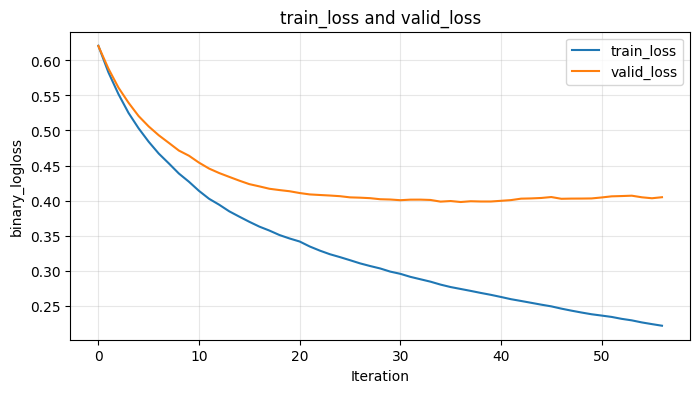

Sex         1020.680608
Age          589.970572
Fare         405.479178
Pclass       299.494368
SibSp         74.489982
Embarked      68.764225
Parch         11.004573
dtype: float64

In [60]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# train/valid 分割
train_x, valid_x, train_y, valid_y = train_test_split(
    X_train, Y_train, test_size=0.33, random_state=0
)

# 学習経過を記録する辞書
evals_result = {}

# LGBM分類器
gbm = lgb.LGBMClassifier(objective='binary', importance_type='gain', n_estimators=1000)

gbm.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (valid_x, valid_y)],
    eval_names=['train', 'valid'],                # 名前を付ける
    eval_metric='binary_logloss',                 # 監視する指標
    callbacks=[
        lgb.early_stopping(20),                   # 20回改善しなければ打ち切り
        lgb.log_evaluation(0),                    # ログ不要なら0
        lgb.record_evaluation(evals_result),      # 結果を evals_result に記録
    ],
)

# loss曲線のプロット
plt.figure(figsize=(8, 4))
plt.plot(evals_result['train']['binary_logloss'], label='train_loss')
plt.plot(evals_result['valid']['binary_logloss'], label='valid_loss')
plt.xlabel('Iteration')
plt.ylabel('binary_logloss')
plt.title('train_loss and valid_loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 特徴量重要度（おまけ）
importances = pd.Series(gbm.feature_importances_, index=train_x.columns)
importances.sort_values(ascending=False).head(20)

In [62]:
# 目的変数
Y_train = train['Survived']

# 特徴量に使う列（PassengerId, Survived を除く）
feature_cols = [c for c in train.columns if c not in ['PassengerId', 'Survived']]

X_train = train[feature_cols]
X_test  = test[feature_cols]

In [63]:
from sklearn.model_selection import train_test_split

# train/valid 分割
train_x, valid_x, train_y, valid_y = train_test_split(
    X_train, Y_train, test_size=0.33, random_state=0
)

# LGBM分類器
gbm = lgb.LGBMClassifier(objective='binary', importance_type='gain', n_estimators=1000)

evals_result = {}
gbm.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (valid_x, valid_y)],
    eval_names=['train', 'valid'],
    eval_metric='binary_logloss',
    callbacks=[
        lgb.early_stopping(20),
        lgb.log_evaluation(0),
        lgb.record_evaluation(evals_result),
    ],
)

# テストデータで予測
test_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_).astype(int)

[LightGBM] [Info] Number of positive: 231, number of negative: 365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 596, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.387584 -> initscore=-0.457480
[LightGBM] [Info] Start training from score -0.457480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

In [65]:
# もう一度 test の「生データ」を読む
test_org = pd.read_csv('../input/titanic/test.csv')

# 予測はこれまで通り
test_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_).astype(int)

# 提出用データフレーム
submission = pd.DataFrame({
    'PassengerId': test_org['PassengerId'],
    'Survived': test_pred
})
submission.to_csv('../submission_titanic_lgbm.csv', index=False)